In [14]:
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

In [6]:
# Load the image in grayscale
image1 = tiff.imread('interview_images/premerge.tif')
image2 = tiff.imread('interview_images/t24.tif')

In [7]:
image1.shape,image2.shape

((5, 1024, 1024), (5, 1024, 1024))

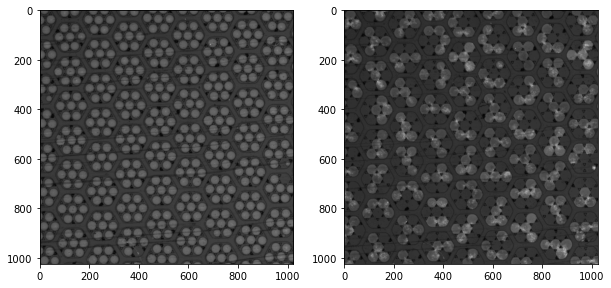

In [207]:
pre_c1=image1[0,:,:]
post_c1=image2[0,:,:]
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(pre_c1,cmap='gray')
ax[1].imshow(post_c1,cmap='gray')

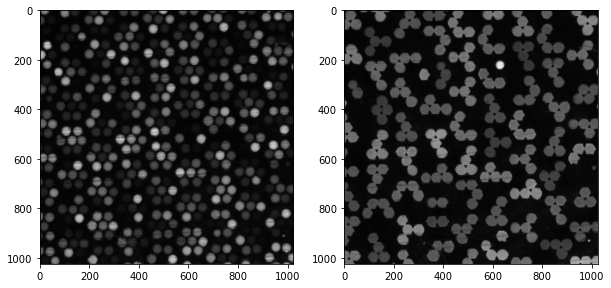

In [208]:
pre_c2=image1[1,:,:]
post_c2=image2[1,:,:]
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(pre_c2,cmap='gray')
ax[1].imshow(post_c2,cmap='gray')

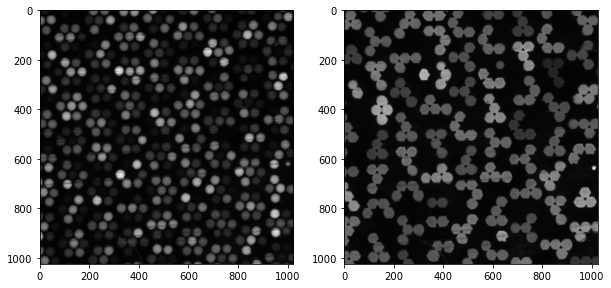

In [209]:
pre_c3=image1[2,:,:]
post_c3=image2[2,:,:]
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(pre_c3,cmap='gray')
ax[1].imshow(post_c3,cmap='gray')

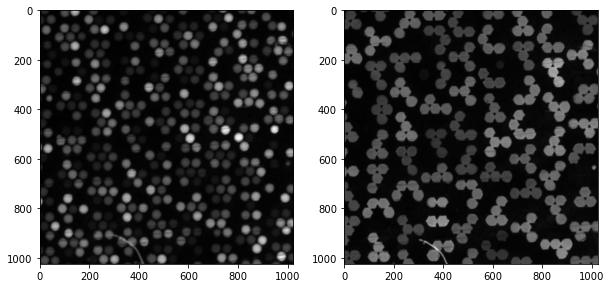

In [210]:
pre_c4=image1[3,:,:]
post_c4=image2[3,:,:]
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(pre_c4,cmap='gray')
ax[1].imshow(post_c4,cmap='gray')

In [15]:
pre_c5=image1[4,:,:]
post_c5=image2[4,:,:]

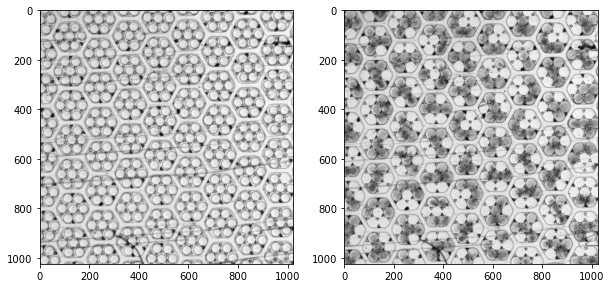

In [17]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(pre_c5,cmap='gray')
ax[1].imshow(post_c5,cmap='gray')

In [28]:
min_value = np.min(pre_c5)
max_value = np.max(pre_c5)
pre_c5_sc = ((pre_c5 - min_value) / (max_value - min_value) * 255).astype(np.uint8)
min_value = np.min(post_c5)
max_value = np.max(post_c5)
post_c5_sc = ((post_c5 - min_value) / (max_value - min_value) * 255).astype(np.uint8)

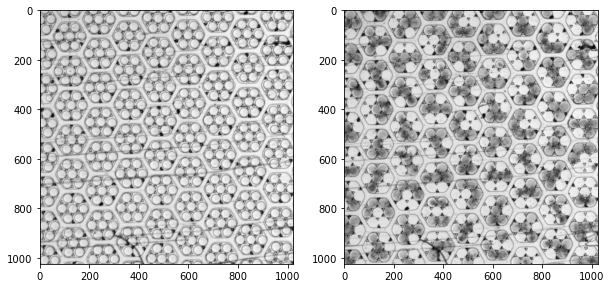

In [30]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(pre_c5_sc,cmap='gray')
ax[1].imshow(post_c5_sc,cmap='gray')

In [31]:
pre_c5_sc.dtype,post_c5_sc.dtype

(dtype('uint8'), dtype('uint8'))

### Edge detection

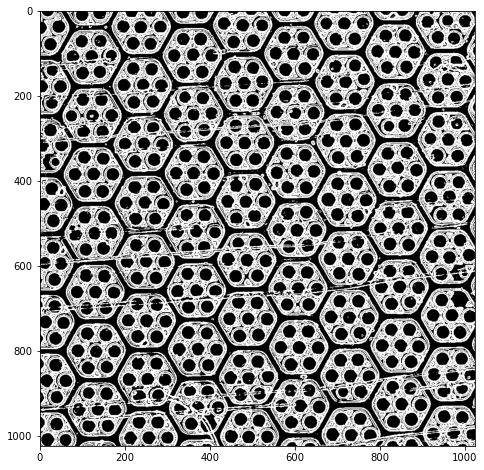

In [75]:
# Compute the gradient using the Sobel operator
gradient_x = cv2.Sobel(pre_c5_sc, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(pre_c5_sc, cv2.CV_64F, 0, 1, ksize=3)

# Compute the gradient magnitude
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

# Apply thresholding to detect edges
threshold = 80  # Adjust the threshold as needed
edge_image1 = (gradient_magnitude > threshold).astype(np.uint8) * 255

# Display the edge-detected image
plt.figure(figsize=(8,8))
plt.imshow(edge_image1,cmap='gray')

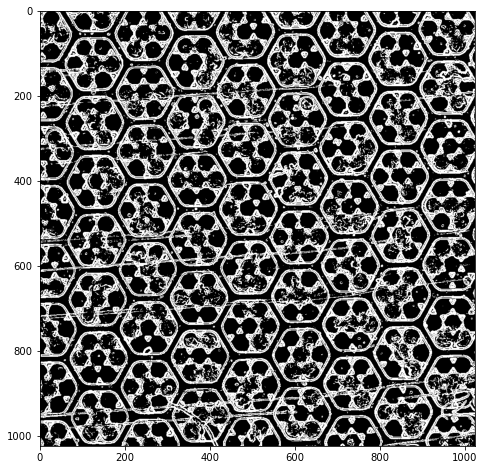

In [47]:
# Compute the gradient using the Sobel operator
gradient_x = cv2.Sobel(post_c5_sc, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(post_c5_sc, cv2.CV_64F, 0, 1, ksize=3)

# Compute the gradient magnitude
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

# Apply thresholding to detect edges
threshold = 90  # Adjust the threshold as needed
edge_image2 = (gradient_magnitude > threshold).astype(np.uint8) * 255

# Display the edge-detected image
plt.figure(figsize=(8,8))
plt.imshow(edge_image2,cmap='gray')

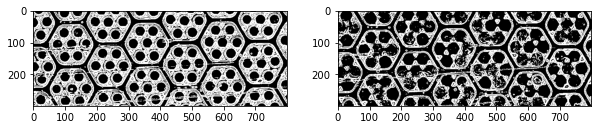

In [166]:
edge1_sub=edge_image1[:300,:800]
edge2_sub=edge_image2[:300,:800]
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(edge1_sub,'gray')
ax[1].imshow(edge2_sub,'gray')

In [158]:
from skimage import morphology

def fill_small_holes(image, hole_size_threshold):
    # Convert the input image to binary format
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Perform morphological closing to fill small holes
    filled_image = morphology.binary_closing(binary_image, morphology.disk(hole_size_threshold))

    # Convert the filled binary image back to grayscale
    filled_image = filled_image.astype(np.uint8) * 255

    return filled_image

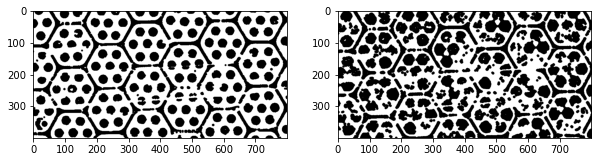

In [159]:
edge1_sub_fh= fill_small_holes(edge1_sub, 3)
edge2_sub_fh= fill_small_holes(edge2_sub, 4)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(edge1_sub_fh,'gray')
ax[1].imshow(edge2_sub_fh,'gray')

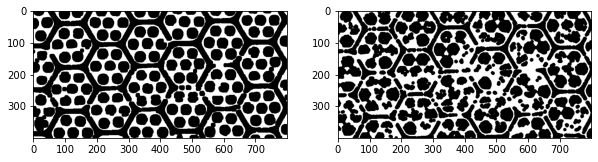

In [188]:
# Define the kernel (structuring element) for erosion
kernel1 = np.ones((3, 3), np.uint8)  # You can adjust the kernel size
kernel2 = np.ones((3, 3), np.uint8)
# Erode the image
edge1_sub_er = cv2.erode(edge1_sub_fh, kernel1, iterations=3)
edge2_sub_er = cv2.erode(edge2_sub_fh, kernel2, iterations=1)

fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(edge1_sub_er,'gray')
ax[1].imshow(edge2_sub_er,'gray')

### Registration

In [167]:
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift

shift, error, diffphase = phase_cross_correlation(edge_image1, edge_image2)
shift

array([-17.,  -6.])

In [203]:
from skimage import transform
tform = transform.EuclideanTransform(
    translation = (-6, -17)
    )
tf_img = transform.warp(edge2_sub, tform.inverse)

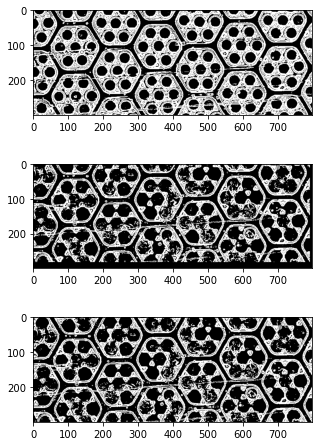

In [204]:
# Display the registered image
fig,ax=plt.subplots(3,1,figsize=(5,8))
ax[0].imshow(edge1_sub,'gray')
ax[2].imshow(edge2_sub,'gray')
ax[1].imshow(tf_img,'gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


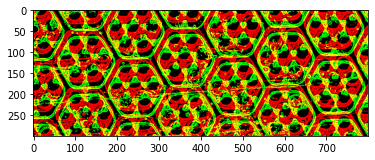

In [205]:
rgb_org = np.zeros((edge1_sub.shape[0],edge1_sub.shape[1],3))
rgb_org[:,:,0]=edge1_sub
rgb_org[:,:,1]=edge2_sub
plt.imshow (rgb_org)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


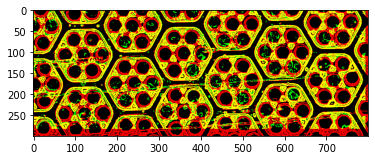

In [206]:
rgb_reg = np.zeros((edge1_sub.shape[0],edge1_sub.shape[1],3))
rgb_reg[:,:,0]=edge1_sub
rgb_reg[:,:,1]=tf_img
plt.imshow (rgb_reg)